# Training the REAL/FAKE classifier

In [ ]:
from fastai.core import *
from fastai.vision import *
from efficientnet_pytorch import EfficientNet

In [ ]:
path = Path('../data/HardDeepFakes/')
src = ImageList.from_folder(path).split_by_folder(train='train', valid='val')

In [ ]:
def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).png$')
           .transform(get_transforms(max_warp=0, max_zoom=1), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

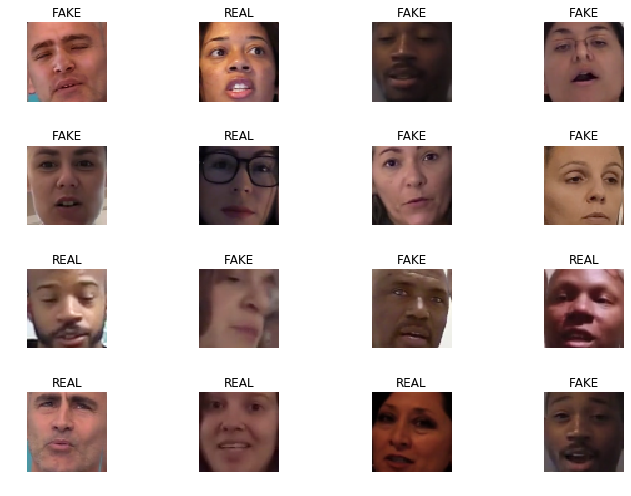

In [ ]:
bs, sz = 32, 64
data = get_data(bs, sz)
data.show_batch(rows=4, figsize=(10,7))

## Resnet

In [ ]:
model = models.resnet18(num_classes=2)

In [ ]:
import copy

In [ ]:
fc = copy.deepcopy(model.fc)

In [ ]:
model.fc = nn.Identity()

In [ ]:
state_dict = torch.load('models/resnet_oselect_dfdc.pth')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [ ]:
model.fc = fc

In [ ]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
learn = Learner(data, model, path='./', metrics=[accuracy])

In [ ]:
learn.lr_find(start_lr=1e-11, end_lr=1e-7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


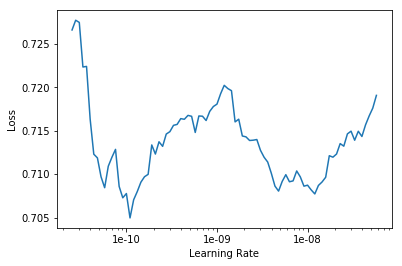

In [ ]:
learn.recorder.plot(skip_end=5)

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.711658,0.714238,0.500000,00:43
1,0.710710,0.706583,0.522500,00:41
2,0.703991,0.704125,0.492500,00:41
3,0.703532,0.702864,0.472500,00:43
4,0.700790,0.702296,0.485000,00:44


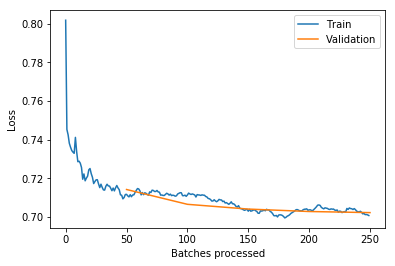

In [ ]:
learn.recorder.plot_losses()

## EfficientNetB0

### Transfer from Imagenet

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [ ]:
learn = Learner(data, model, metrics=[accuracy]).to_fp16()

In [ ]:
fm = flatten_model(model)
learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [ ]:
learn.freeze_to(-1)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


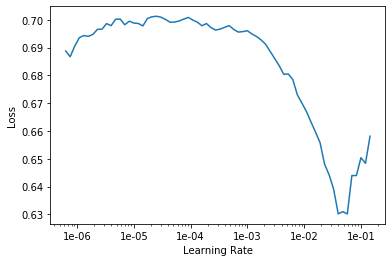

In [ ]:
learn.recorder.plot(skip_end=10)

In [ ]:
learn.fit_one_cycle(cyc_len=10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.617744,0.752598,0.610127,00:09
1,0.457196,1.634969,0.564557,00:09
2,0.347240,2.463516,0.511392,00:09
3,0.220700,1.524742,0.587342,00:09
4,0.166339,0.919773,0.675949,00:09
5,0.122946,0.688545,0.827848,00:09
6,0.082851,1.569407,0.683544,00:09
7,0.069489,0.493424,0.835443,00:09
8,0.065225,0.345136,0.875949,00:09
9,0.047185,0.329459,0.875949,00:09


In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


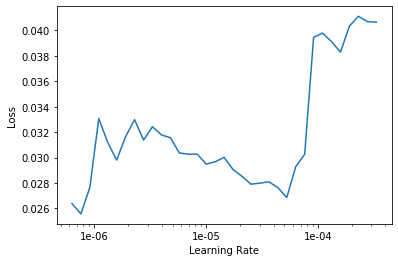

In [ ]:
learn.recorder.plot(skip_end=10)

In [ ]:
learn.fit_one_cycle(cyc_len=20, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.028184,0.340965,0.888608,00:13
1,0.034338,0.322491,0.893671,00:13
2,0.030835,0.359860,0.896203,00:13
3,0.030754,0.351067,0.893671,00:13
4,0.025589,0.426322,0.888608,00:13
5,0.028927,0.510527,0.868354,00:13
6,0.034488,0.501700,0.883544,00:13
7,0.029113,0.453318,0.898734,00:13
8,0.028673,0.289805,0.916456,00:13
9,0.026317,0.298830,0.903797,00:13


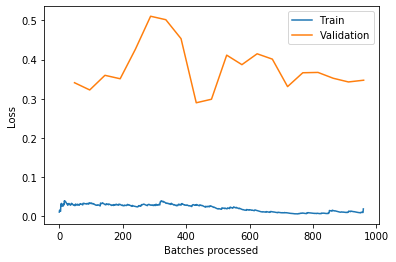

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('effnet_classifier_fromimagenette')

In [ ]:
learn.path

PosixPath('../data/EasyDeepFakes')

### Transfer from Online Selection

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [ ]:
import copy

In [ ]:
swish0 = copy.deepcopy(model._swish)
fc0 = copy.deepcopy(model._fc)
dropout0 = copy.deepcopy(model._dropout)

In [ ]:
model._swish = nn.Identity()
model._fc = nn.Identity()
model._dropout = nn.Identity()

In [ ]:
state_dict = torch.load('../nbs/models/effnetb0_oselect_dfdc.pth')

In [ ]:
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [ ]:
model._swish = swish0
model._fc = fc0
model._dropout = dropout0

In [ ]:
learn = Learner(data, model, metrics=[accuracy])

In [ ]:
#fm = flatten_model(model)
#learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [ ]:
#learn.freeze_to(-1)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


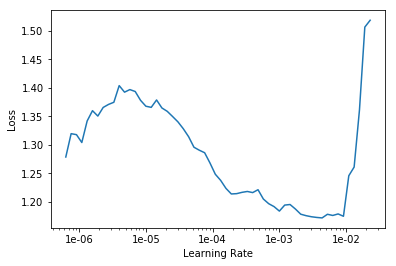

In [ ]:
learn.recorder.plot(skip_end=10)

In [ ]:
learn.fit_one_cycle(cyc_len=2, max_lr=5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.940425,165290.953125,0.495000,01:37
1,0.921353,1024.902954,0.487500,01:38


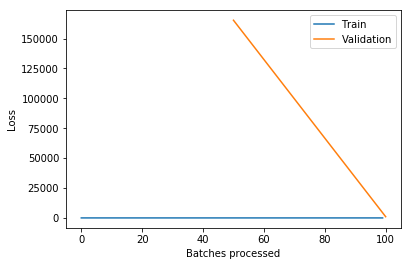

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('effnetb0_classifier_fromoselect')

# -fin